# Code

In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from ConfigParser import SafeConfigParser
from operator import add
from pyspark.mllib.recommendation import ALS, Rating
import random 
from random import randint
import itertools
from math import sqrt
import numpy as np
from pprint import pprint
import math
from ConfigParser import SafeConfigParser
import pandas as pd


def get_parser(names):
    def loadRecord(line):
        cells = line.strip().split('\t')
        return dict(zip(names, cells))
    return loadRecord

def get_lang2id_maps(languages):
    lang2id = {}
    id2lang = {}
    for i, lang in enumerate(languages):
        lang2id[lang] = i
        id2lang[i] = lang
    return lang2id, id2lang

def toRating(x):
    user_id = lang2id[x['lang']]
    item_id=int(x['id'][1:])
    counts = float(x['pageview_count'])
    return (user_id, item_id, counts)

def load_pageviews(sc, filename, k=3):
    names = [ 'id', 'lang', 'title', 'pageview_count']
    pageviews = sc.textFile(filename)\
    .map(get_parser(names))\
    .filter(lambda x: len(x) == 4)\
    .filter(lambda x: x['lang'] in languages_set)\
    .map(lambda x: (x['id'], x))\
    .groupByKey().filter(lambda x: len(x[1]) >=k ).flatMap(lambda x: x[1])\
    .map(toRating)
    return pageviews


def split_train_validation_test(triples, splits = [6, 8], numPartitions = 100):
    # split ratings into train (60%), validation (20%), and test (20%) 
    random.seed(2)
    split_triples = triples.map(lambda x: (random.randint(0,9),x ))
    split1, split2 = splits
    
    training = split_triples.filter(lambda x: x[0] < split1) \
      .values() \
      .repartition(numPartitions) \
      .cache()
    validation = split_triples.filter(lambda x: x[0] >= split1 and x[0] < split2) \
      .values() \
      .repartition(numPartitions) \
      .cache()

    test = split_triples.filter(lambda x: x[0] >= split2).values().cache()
    numTraining = training.count()
    numValidation = validation.count()
    numTest = test.count()
    print "Training: %d, validation: %d, Test: %d" % (numTraining, numValidation, numTest)
    return training, validation, test



def computeRmse(model, data, n):
    """
    Compute RMSE (Root Mean Squared Error).
    """
    predictions = model.predictAll(data.map(lambda x: (x[0], x[1])))
    predictionsAndRatings = predictions.map(lambda x: ((x[0], x[1]), x[2])) \
      .join(data.map(lambda x: ((x[0], x[1]), x[2]))) \
      .values()
    return sqrt(predictionsAndRatings.map(lambda x: (x[0] - x[1]) ** 2).reduce(add) / float(n))


def cross_validation(training, validation, test, all_triplets, ranks, lambdas, numIters):
# train models and evaluate them on the validation set

    result_dict = {}
    result_template = "rank:%d  iters:%d  lambda: %f"
    bestModel = None
    bestValidationRmse = float("inf")
    bestRank = 0
    bestLambda = -1.0
    bestNumIter = -1
    numTraining = training.count()
    numValidation = validation.count()
    numTest = test.count()
    
    for lmbda, numIter, rank in itertools.product(lambdas, numIters, ranks):
        model = ALS.train(training, rank, iterations = numIter,  lambda_ = lmbda, nonnegative=True, seed=10)
        validationRmse = computeRmse(model, validation, numValidation)
        print "RMSE (validation) = %f for the model trained with " % validationRmse + \
              "rank = %d, lambda = %.4f, and numIter = %d." % (rank, lmbda, numIter)

        if (validationRmse < bestValidationRmse):
            bestModel = model
            bestValidationRmse = validationRmse
            bestRank = rank
            bestLambda = lmbda
            bestNumIter = numIter
        result_dict[result_template % (rank, numIter, lmbda)] = validationRmse
    testRmse = computeRmse(bestModel, test, numTest)
    # evaluate the best model on the test set
    print "The best model was trained with rank = %d and lambda = %.1f, " % (bestRank, bestLambda) \
      + "and numIter = %d, and its RMSE on the test set is %f." % (bestNumIter, testRmse)
    result_dict['BEST Model on Test:' + result_template % (bestRank, bestNumIter, bestLambda)] = testRmse
    # compare the best model with a naive baseline that always returns the mean rating
    meanRating = training.union(validation).map(lambda x: x[2]).mean()
    _ , baselineRmse = compute_baseline(training, validation, test)
    improvement = (baselineRmse - testRmse) / baselineRmse * 100
    print "The best model improves the baseline by %.2f" % (improvement) + "%."
    result_dict['BEST gain over baseline'] = improvement

    return bestModel, result_dict


def compute_baseline(training, validation, test):
    dt = pd.DataFrame(training.union(validation).collect())
    dt.columns = ['lang', 'id', 'rating']
    lang_means = dt[['lang', 'rating']].groupby('lang').mean()
    dt = pd.DataFrame(test.collect())
    dt.columns = ['lang', 'id', 'rating']
    dt = dt.merge(lang_means, how='inner', left_on='lang',  right_index=True, sort=False)
    def error(x):
        return (x['rating_x'] - x['rating_y'])**2      
    ss = dt.apply(error, axis=1).sum()
    
    return lang_means,  math.sqrt(ss / dt.shape[0])
    
def print_baseline(training, validation, test):
    lang_means, rmse = compute_baseline(training, validation, test)
    print "Mean Ratings:"
    print (lang_means)
    print "RMSE (test):  %f" % rmse
    

def get_named_rankings(cp, model):
    missing_articles_file = os.path.join(cp.get('general', 'local_data_dir'), 'en-es', cp.get('missing', 'ranked_missing_items'))
    d = pd.read_csv(missing_articles_file, sep='\t', names = ['id', 'name', 'score'], encoding = 'utf8')
    d['id'] = d['id'].apply(lambda x: int(x[1:]))
    id2name = dict(zip(d['id'], d['name']))
    
    es_id = lang2id['es']
    missing_articles_file = os.path.join(cp.get('general', 'hadoop_data_dir'), 'en-es', cp.get('missing', 'ranked_missing_items'))
    missing_articles = sc.textFile(missing_articles_file)\
                                         .map(lambda x: x.split('\t'))\
                                         .map(lambda x: (es_id, int(x[0][1:])))
    predictions = model.predictAll(missing_articles).map(lambda x: (x.product, x.rating)).collect()
    d_als = pd.DataFrame(predictions)
    d_als.columns = ['id', 'score']
    d_als['name'] = d_als['id'].apply(lambda x: id2name[x] if x in id2name else u'')
    df = pd.merge(left = d, right = d_als, on = 'id')[['id', 'name_x', 'score_x', 'score_y']]
    df.columns = ['id', 'name', 'en_pageviews', 'score']
    
    return df.sort('score', ascending = False)
    

def project(model, normalize=False):
    lang_vecs = model.userFeatures().collect()
    
    if normalize:
        lang_vecs = [t[1] / np.linalg.norm(t[1]) for t in lang_vecs]
    else:
        lang_vecs = [t[1]  for t in lang_vecs]
    A = [t[0] for t in lang_vecs]
    B = [t[1] for t in lang_vecs]

    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.scatter(A,B)
    for i, xy in enumerate(zip(A, B)):                                                
        ax.annotate(languages[i], xy=xy, textcoords='offset points') 

    plt.grid()
    plt.show()

#languages = ['ar', 'bg', 'ca', 'ceb', 'cs','da','de','el','en','eo','es','et','eu','fa','fi','fr','gl','he','hi','hr','hu','hy','id','it','ja','kk','ko','lt','ms','nl','nn','no','pl','pt','ro','ru','sh','simple','sk','sl','sr','sv','tr','uk','uz','vi','war','zh','min','vo']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#Analysis

 To start, lets only use data from the top 9 wikipedias and only include items that exist in at least 2 languages

In [3]:
config = '/home/ellery/wikimedia/missing_articles/missing_articles.ini'
cp = SafeConfigParser()
cp.read(config)

languages = ['en', 'de', 'fr', 'es', 'nl', 'ru', 'ja', 'sv', 'pl']
languages_set = set(languages)
lang2id, id2lang = get_lang2id_maps(languages)
pageviews = load_pageviews(sc, cp.get('general', 'pageviews'), k=2) 

# Rank Transformation

Within each language rank articles by the number of views and assign article a the score 1 - rank(a) / n. Think of this as continuos equal frquency binning.

### Transform Data

In [23]:

def get_ranking_score(t):
    lang_id, items = t
    ids = np.array([x[0] for x in items])
    item_ranks = np.argsort(np.array([x[1] for x in items]))
    print item_ranks
    n = float(len(items))
    return [(lang_id, ids[r], i/n) for i, r in enumerate(item_ranks)]
       
rank_pageviews = pageviews.map(lambda x: (x[0], (x[1], x[2]))).groupByKey().flatMap(get_ranking_score)
training, validation, test = split_train_validation_test(rank_pageviews)

Training: 6431440, validation: 2148364, Test: 2146015


### Compute Baseline (mean "user" rating)
We can use the mean score per language as a simple baseline.

In [24]:
print_baseline(training, validation, test)

Mean Ratings:
        rating
lang          
0     0.500340
1     0.499976
2     0.500022
3     0.500104
4     0.500472
5     0.500234
6     0.500259
7     0.500325
8     0.499927
RMSE (test):  0.288754


### CV : Lets find the best model

In [43]:
ranks = [1,2,3]
numIters = [15]
lambdas = [0.01, 0.03, 0.05, 0.08]
model, cv_results = cross_validation(training, validation, test, pageviews, ranks, lambdas, numIters)

RMSE (validation) = 0.173174 for the model trained with rank = 1, lambda = 0.0100, and numIter = 15.
RMSE (validation) = 0.177248 for the model trained with rank = 2, lambda = 0.0100, and numIter = 15.
RMSE (validation) = 0.185956 for the model trained with rank = 3, lambda = 0.0100, and numIter = 15.
RMSE (validation) = 0.173835 for the model trained with rank = 1, lambda = 0.0300, and numIter = 15.
RMSE (validation) = 0.170992 for the model trained with rank = 2, lambda = 0.0300, and numIter = 15.
RMSE (validation) = 0.174296 for the model trained with rank = 3, lambda = 0.0300, and numIter = 15.
RMSE (validation) = 0.176747 for the model trained with rank = 1, lambda = 0.0500, and numIter = 15.
RMSE (validation) = 0.173950 for the model trained with rank = 2, lambda = 0.0500, and numIter = 15.
RMSE (validation) = 0.176301 for the model trained with rank = 3, lambda = 0.0500, and numIter = 15.
RMSE (validation) = 0.185133 for the model trained with rank = 1, lambda = 0.0800, and numI

The rank 2 model is insignificantly better than the rank 1 model. A rank 1 model means that articles have the same ranking within each language. Not really waht we were hoping for.

### Inspect Ranking of EN articles missing in ES

In [87]:
df = get_named_rankings(cp)

In [90]:
df.head(10)

,name,pageviews,score
13667,Conservatorship,51173,1.042220
2922,Yu-Gi-Oh! Duel Monsters,120147,1.039728
1860,Shirobako,151589,1.038770
281,Corporate title,386458,1.038457
14617,Compliance,49167,1.037608
31622,Massan,29756,1.036183
7652,The Fruit of Grisaia,71237,1.036123
68893,Sota Fukushi,15853,1.036075
695,Lord Marksman and Vanadis,249141,1.036067
352782,Ga (kana),2450,1.036019


 Why are Japanese articles dominating the ranking?

In [91]:
df.sort('pageviews', ascending = False).head()

,name,pageviews,score
0,NASA Helios,6462135,0.827147
1,Line integral convolution,5312288,0.552656
2,Deaths in 2015,4444490,0.965520
3,Ingres (database),4302270,0.774785
4,NASA Pathfinder,4213272,0.695580


### Project Languages into 2D
We can run ALS with rank 2 and see what languages end up close to each other

In [ ]:
model = ALS.train(training, 2, iterations = 15,  lambda_ = 0.03, nonnegative=True, seed=10)

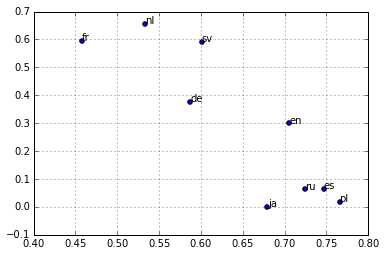

In [93]:
project(model, normalize=False)

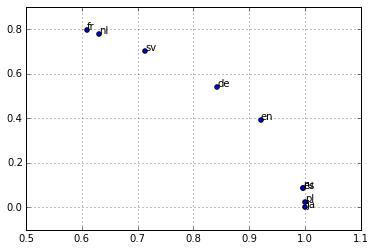

In [94]:
project(model, normalize=True)

# Log Transformation

### Transform

In [4]:
pageviews = load_pageviews(sc, cp.get('general', 'pageviews'), k=2) 
log_pageviews = pageviews.map(lambda x: (x[0], x[1], math.log( max(1.0, x[2]))))
training, validation, test = split_train_validation_test(log_pageviews)

Training: 6436642, validation: 2148391, Test: 2143711


### Visualize Distributions

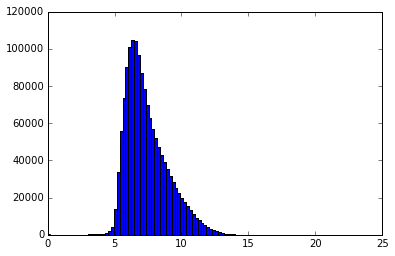

In [101]:
views = training.filter(lambda x: x[0] == 0).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

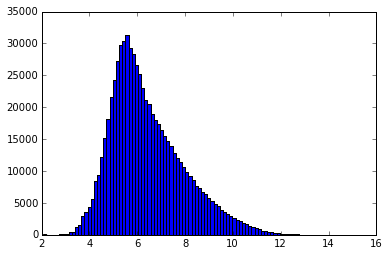

In [102]:
views = training.filter(lambda x: x[0] == 1).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

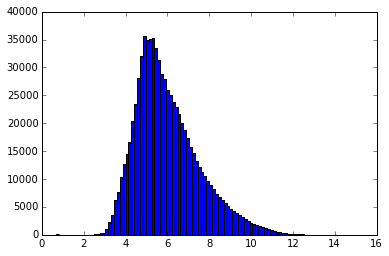

In [103]:
views = training.filter(lambda x: x[0] == 2).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

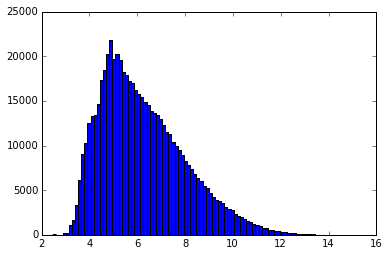

In [104]:
views = training.filter(lambda x: x[0] == 3).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

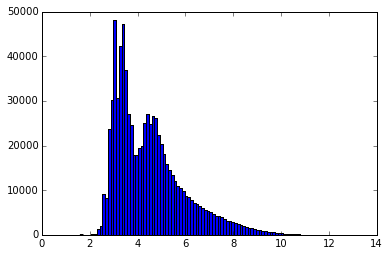

In [105]:
views = training.filter(lambda x: x[0] == 4).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

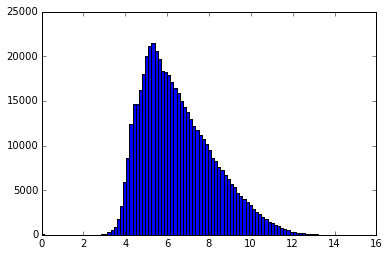

In [106]:
views = training.filter(lambda x: x[0] == 5).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

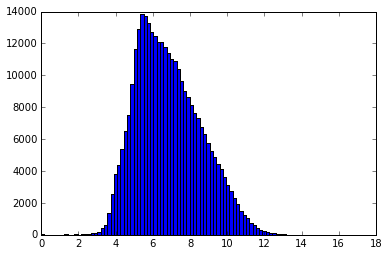

In [107]:
views = training.filter(lambda x: x[0] == 6).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

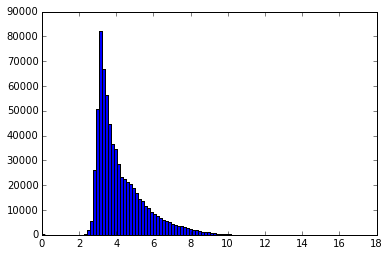

In [108]:
views = training.filter(lambda x: x[0] == 7).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

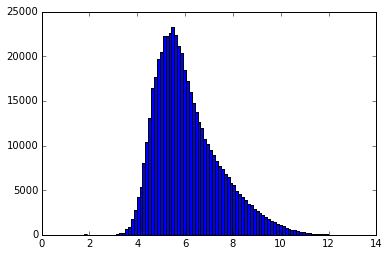

In [109]:
views = training.filter(lambda x: x[0] == 8).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

### Compute Baseline (mean "user" rating)

In [47]:
print_baseline(training, validation, test)

Mean Ratings:
        rating
lang          
0     7.394563
1     6.417169
2     5.992262
3     6.234379
4     4.484033
5     6.517464
6     6.831579
7     4.203344
8     6.096160
RMSE (test):  1.542293


### CV 

In [112]:
ranks = [2]
numIters = [15]
lambdas = [0.001, 0.01, 0.05, 0.1, 1.0]
model, cv_results = cross_validation(training, validation, test, pageviews, ranks, lambdas, numIters)

RMSE (validation) = 0.960728 for the model trained with rank = 2, lambda = 0.0010, and numIter = 15.
RMSE (validation) = 0.907979 for the model trained with rank = 2, lambda = 0.0100, and numIter = 15.
RMSE (validation) = 0.805965 for the model trained with rank = 2, lambda = 0.0500, and numIter = 15.
RMSE (validation) = 0.755540 for the model trained with rank = 2, lambda = 0.1000, and numIter = 15.
RMSE (validation) = 1.237602 for the model trained with rank = 2, lambda = 1.0000, and numIter = 15.
The best model was trained with rank = 2 and lambda = 0.1, and numIter = 15, and its RMSE on the test set is 0.766996.
The best model improves the baseline by 59.21%.


In [120]:
ranks = [1]
numIters = [15]
lambdas = [0.001, 0.01, 0.05, 0.1, 1.0]
model, cv_results = cross_validation(training, validation, test, pageviews, ranks, lambdas, numIters)

RMSE (validation) = 0.762301 for the model trained with rank = 1, lambda = 0.0010, and numIter = 15.
RMSE (validation) = 0.761977 for the model trained with rank = 1, lambda = 0.0100, and numIter = 15.
RMSE (validation) = 0.761811 for the model trained with rank = 1, lambda = 0.0500, and numIter = 15.
RMSE (validation) = 0.764644 for the model trained with rank = 1, lambda = 0.1000, and numIter = 15.
RMSE (validation) = 1.237599 for the model trained with rank = 1, lambda = 1.0000, and numIter = 15.
The best model was trained with rank = 1 and lambda = 0.1, and numIter = 15, and its RMSE on the test set is 0.768265.
The best model improves the baseline by 59.20%.


A rank 1 approximation means that articles have the same ranking within each language. Not really waht we were hoping for.

### Inspect Ranking of EN articles missing in ES

In [121]:
df = get_named_rankings(cp, model)

In [122]:
df.head(10)

,name,pageviews,score
31705,Massan,29756,14.309044
4516,Jeannette Bougrab,95949,13.884616
77859,Wallander (film series),14213,13.740674
34522,Charlotte Kate Fox,27971,13.718313
160,Your Lie in April,520615,13.586271
333045,Belarusian National Technical University,2658,13.574096
422181,Love Antell,1887,13.553452
19491,Telephone numbers in the Netherlands,41335,13.513248
217208,Jönssonligan,4690,13.488244
539,Ebolavirus,289408,13.424642


Looks like there are articles popular in a mix of countries among the top ranked articles

### Project Languages
We can run ALS with rank 2 and see what languages end up close to each other

In [ ]:
model = ALS.train(training, 2, iterations = 15,  lambda_ = 0.1, nonnegative=True, seed=10)

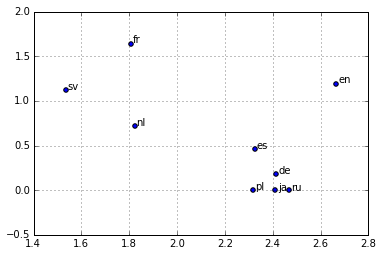

In [118]:
project(model, normalize=False)

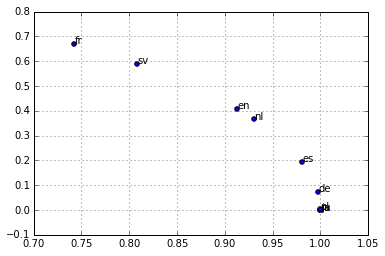

In [119]:
project(model, normalize=True)

# Log + Normalize Rows Transformarion

### Transform

In [25]:
log_pageviews = pageviews.map(lambda x: (x[0], x[1], math.log( max(1.0, x[2]))))
user_normalization_constants = dict(log_pageviews.map(lambda x: (x[0], x[2])).reduceByKey(add).collect())
print "NORMALIZATION CONSTANTS"
pprint(user_normalization_constants)
scale_factor = 100000.0
log_norm_pageviews = log_pageviews.map(lambda x: (x[0], x[1], (scale_factor*x[2])/user_normalization_constants[x[0]]))
training, validation, test = split_train_validation_test(log_norm_pageviews)

NORMALIZATION CONSTANTS
{0: 18329214.416625448,
 1: 7421456.765657312,
 2: 7926217.643698666,
 3: 6237313.184675915,
 4: 6026920.662480737,
 5: 5677050.307488076,
 6: 3662377.933163915,
 7: 4863420.026699739,
 8: 5264657.804982263}
Training: 6426665, validation: 2144696, Test: 2148670


### Visualize Distributions

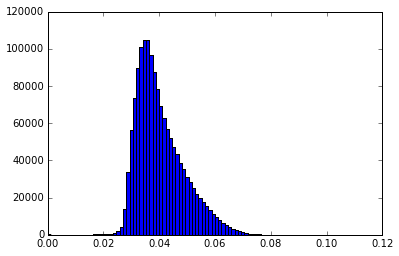

In [26]:
views = training.filter(lambda x: x[0] == 0).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

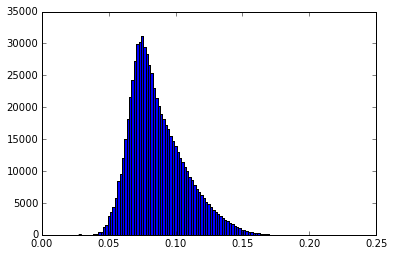

In [27]:
views = training.filter(lambda x: x[0] == 1).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

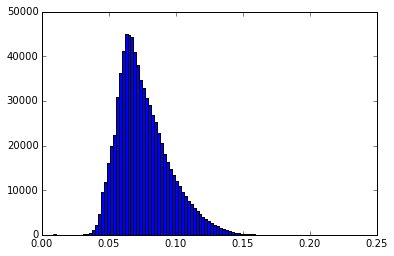

In [28]:
views = training.filter(lambda x: x[0] == 2).map(lambda x: x[2]).collect()
x = plt.hist(np.array(views), bins = 100)

### Compute Baseline (mean "user" rating)

In [29]:
print_baseline(training, validation, test)

Mean Ratings:
        rating
lang          
0     0.040348
1     0.086446
2     0.075603
3     0.099973
4     0.074435
5     0.114784
6     0.186540
7     0.086407
8     0.115822
RMSE (test):  0.023934


### CV

In [30]:
ranks = [1,2,3]
numIters = [15]
lambdas = [0.0001, 0.00025, 0.0005, 0.0008, 0.001]
model, cv_results = cross_validation(training, validation, test, pageviews, ranks, lambdas, numIters)

RMSE (validation) = 0.011655 for the model trained with rank = 1, lambda = 0.0001, and numIter = 15.
RMSE (validation) = 0.014093 for the model trained with rank = 2, lambda = 0.0001, and numIter = 15.
RMSE (validation) = 0.016067 for the model trained with rank = 3, lambda = 0.0001, and numIter = 15.
RMSE (validation) = 0.011725 for the model trained with rank = 1, lambda = 0.0003, and numIter = 15.
RMSE (validation) = 0.012603 for the model trained with rank = 2, lambda = 0.0003, and numIter = 15.
RMSE (validation) = 0.012545 for the model trained with rank = 3, lambda = 0.0003, and numIter = 15.
RMSE (validation) = 0.011791 for the model trained with rank = 1, lambda = 0.0005, and numIter = 15.
RMSE (validation) = 0.011759 for the model trained with rank = 2, lambda = 0.0005, and numIter = 15.
RMSE (validation) = 0.011690 for the model trained with rank = 3, lambda = 0.0005, and numIter = 15.
RMSE (validation) = 0.011844 for the model trained with rank = 1, lambda = 0.0008, and numI

### Inspect Ranking of EN articles missing in ES

In [21]:
df = get_named_rankings(cp, model)

In [22]:
df.head(10)

,id,name,en_pageviews,score
532,5331908,Ebolavirus,289408,0.251467
5010,321149,Freddy Heineken,90148,0.239257
28912,689438,Tatort,31851,0.238903
568464,508894,Åke,1200,0.236506
93839,4568100,David Batra,11891,0.234354
697646,16939437,Kommissar Beck – Die neuen Fälle,860,0.233967
191977,2202089,Familie,5463,0.231994
77842,12986432,Wallander (film series),14213,0.230566
3464,17385969,Kendji Girac,109877,0.229761
654898,5710889,Hem till byn,955,0.227617


### Project Languages
We can run ALS with rank 2 and see what languages end up close to each other

In [19]:
model = ALS.train(training, 2, iterations = 15,  lambda_ = 0.001, nonnegative=True, seed=10)

/home/ellery/anaconda/lib/python2.7/site-packages/matplotlib/text.py:1857: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


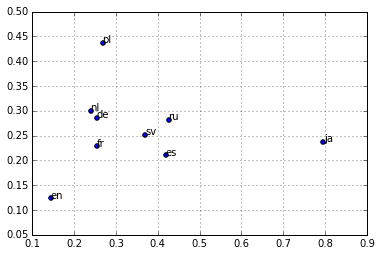

In [7]:
project(model, normalize=False)

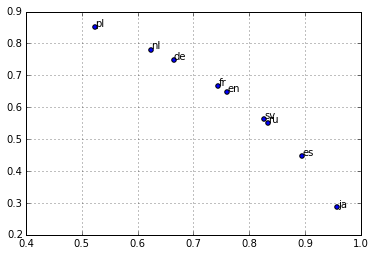

In [10]:
project(model, normalize=True)

#Scratch

In [ ]:
def print_baseline_distributed(training, validation, test):
    numTest = test.count()  
    
    sumUserRatings = training.union(validation)\
    .map(lambda x: (x[0], x[2]))\
    .reduce(add)
    
    numUserRatings = training.union(validation)\
    .map(lambda x: (x[0], 1.0))\
    .reduce(add)
    
    meanUserRatings = sumUserRatings.join(numUserRatings).map(lambda x: (x[0], x[1][0]/x[1][1]))
    meanUserRatings = dict(meanUserRatings.collect())
    baselineRmse = sqrt(test.map(lambda x: (meanUserRatings[x[0]] - x[2]) ** 2).reduce(add) / numTest)
    
    print "Mean Ratings:"
    pprint(meanUserRatings)
    
    print "RMSE (test):  %f" % baselineRmse
    

In [29]:
def to_libsvm(x):
    line = x[0][1:] + ' '
    langs = [str(lang2id[d['lang']]) + ':' + d['pageview_count'] for d in x[1]]
    langs.sort()
    return line + ' '.join(langs)
    
names = [ 'id', 'lang', 'title', 'pageview_count']

k = 3

pageviews = sc.textFile(cp.get('general', 'pageviews'))\
.map(get_parser(names))\
.filter(lambda x: len(x) == 4)\
.filter(lambda x: x['lang'] in languages_set)\
.map(lambda x: (x['id'], x))\
.groupByKey().filter(lambda x: len(x[1]) >=k ).map(to_libsvm)

In [30]:
exp_dir = 'importance'
fname = 'libsvm.txt'
base_dir = os.path.join(cp.get('general', 'local_data_dir'), exp_dir)
hadoop_base_dir = os.path.join(cp.get('general', 'hadoop_data_dir'), exp_dir)
save_rdd(pageviews, base_dir , hadoop_base_dir, fname)

256
0
256
256
0
0
0
0


In [37]:
from sklearn.datasets import load_svmlight_file
X, Y= load_svmlight_file(os.path.join(base_dir, fname))

In [44]:
X = X.T
from sklearn.preprocessing import normalize
X = normalize(X, norm='l2', axis=1, copy=True)

In [45]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X.T.toarray())
print(pca.explained_variance_ratio_) 

[ 0.97762391  0.00994535  0.00675686]


In [41]:
X

<1254410x7 sparse matrix of type '<type 'numpy.float64'>'
	with 5373355 stored elements in Compressed Sparse Row format>